## LAB2

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import time

## Dodano uczenie metodą propagacji błędu wraz z podejściem batchowym oraz wizualizacją sieci

In [2]:
class MLP:

    def __init__(self, weights, bias, num_outputs=1, num_hidden=1, activation_function="sigmoid"):
        self.weights = weights
        self.bias = bias
        self.activation_function = activation_function
        self.num_hidden = len(weights) - 1
        self.num_neurons = [weights[0].shape[0]]

        for i in range(len(weights)):
            self.num_neurons.append(weights[i].shape[1])
        self.num_inputs = self.num_neurons[0]
        self.num_outputs = self.num_neurons[-1]

        # verify if dimensions are correct
        for i in range(len(weights) - 1):
            if (weights[i].shape[1] != weights[i + 1].shape[0]):
                print("Weights' dimensions between layers " + str(i) + " and " + str(i + 1) + "are incorrect!")
        for i in range(len(bias)):
            if (weights[i].shape[1] != bias[i].size):
                print("Bias size in layer " + str(i) + " is incorrect!")

    def forward_prop(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.a = []
        self.z = []

        activation_function = self.get_activation_function(self.activation_function)
        activations = inputs
        self.a.append(activations)
        for i in range(self.num_hidden):
            outputs = np.dot(activations, self.weights[i]) + self.bias[i]
            self.z.append(outputs)
            activations = activation_function(outputs)
            self.a.append(activations)

        results = np.dot(activations, self.weights[self.num_hidden]) + self.bias[self.num_hidden]
        self.z.append(results)
        self.a.append(results)
        return results

    def backpropagation(self, y):
        deltas = [None] * len(self.weights)
        deltas[-1] = y - self.a[-1]
        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = (self.weights[i + 1].dot(deltas[i + 1].T) * (
                self.get_activation_function_derivitive(self.activation_function)(self.z[i]).T)).T
        
        batch_size = y.shape[0]
        db = [d.T.dot(np.ones((batch_size, 1))).T / float(batch_size) for d in deltas]
        dw = [(d.T.dot(self.a[i])).T / float(batch_size) for i, d in enumerate(deltas)]
        return dw, db

    def train(self, x, y, batch_size = 20, epochs = 500, learning_rate = 0.1, verbose = False):
        for epoch in range(epochs):
            i = 0
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward_prop(x_batch)
                dw, db = self.backpropagation(y_batch)
                self.weights = [w + learning_rate * dweight for w, dweight in zip(self.weights, dw)]
                self.bias = [w + learning_rate * dbias for w, dbias in zip(self.bias, db)]
                if verbose or epoch in [0,epochs-1]:
                    print("Epoch: {: <5} Error: {}".format(epoch, np.linalg.norm(self.a[-1] - y_batch)))
                    
    @staticmethod
    def get_activation_function(name):
        if (name == 'sigmoid'):
            return lambda x: np.exp(x) / (1 + np.exp(x))
        elif (name == 'linear'):
            return lambda x: x
        else:
            print('Wrong activation function; linear was used instead')
            return lambda x: x

    @staticmethod
    def get_activation_function_derivitive(name):
        if (name == 'sigmoid'):
            sigmoid = lambda x: np.exp(x) / (1 + np.exp(x))
            return lambda x: sigmoid(x) * (1 - sigmoid(x))
        elif (name == 'linear'):
            return lambda x: 1
        else:
            print('Wrong activation function; linear was used instead')
            return lambda x: 1

    def show_attributes(self):
        """
        gives basic information about the neural network
        """
        print("Neural Network attributes:")
        print("-------------------------")
        print("Number of neurons in layers: {}".format(self.num_neurons))
        print("Number of predictors: {}".format(self.num_inputs))
        print("Number of hidden layers: {}".format(self.num_hidden))
        print("Number of targets: {}".format(self.num_outputs))
        print("Activations function used: {}".format(self.activation_function))
        return
    
    def visualize(self, axis = False):
        x = []
        y = []
        all_weights = []
        all_biases = [None]
        
        for weight in self.weights:
            for row in weight:
                for i in row:
                    all_weights.append(round(i,2))
        for bias in self.bias:
            for row in bias:
                for i in row:
                    all_biases.append(round(i,2))
        weight_counter = 0
        bias_counter = 0
        
        plt.figure(figsize=(20,10))
        
        for i, layer in enumerate(self.num_neurons):            
            layer_points_x = [i] * layer
            layer_points_y = np.linspace(-10, 10, num=layer)
            if layer == 1:
                layer_points_y[0] += 10
            if i==0:
                    previous_layer_x = layer_points_x
                    previous_layer_y = layer_points_y
            else:
                for l1 in previous_layer_y:
                    for l2 in layer_points_y:
                        plt.plot([i-1, i],[l1, l2], color="lightblue")
                        plt.text(i-0.3,0.3*l1+0.7*l2, all_weights[weight_counter], size=15)
                        weight_counter += 1
                previous_layer_x = layer_points_x
                previous_layer_y = layer_points_y
            
            x.extend(layer_points_x)
            y.extend(layer_points_y)
            
        plt.scatter(x,y, color="brown", s=75)
        
        for i, txt in enumerate(all_biases):
            plt.annotate(txt, (x[i], y[i]+0.5), size=15)
        if not axis:
            plt.axis("off")
        plt.title("Neural network graph", fontsize=20)
        plt.show()
        return


def generate_random_mlp(num_inputs, num_hidden, num_targets, start=-10, stop=10):
    """
    generates mlp with random weights given number of neurons in each layer
    """
    weights = []
    bias = []
    weights.append(np.random.uniform(start, stop, num_inputs * num_hidden[0]).reshape(num_inputs, -1))
    for i in range(len(num_hidden) - 1):
        weights.append(np.random.uniform(start, stop, num_hidden[i] * num_hidden[i + 1]).reshape(num_hidden[i], -1))
        bias.append(np.random.uniform(start, stop, num_hidden[i]).reshape(1, -1))
    weights.append(np.random.uniform(start, stop, num_hidden[-1] * num_targets).reshape(-1, num_targets))
    bias.append(np.random.uniform(start, stop, num_hidden[-1]).reshape(1, -1))
    bias.append(np.random.uniform(start, stop, num_targets).reshape(1, -1))
    mlp = MLP(weights, bias)
    return mlp

## Przykładowa wizualizacja

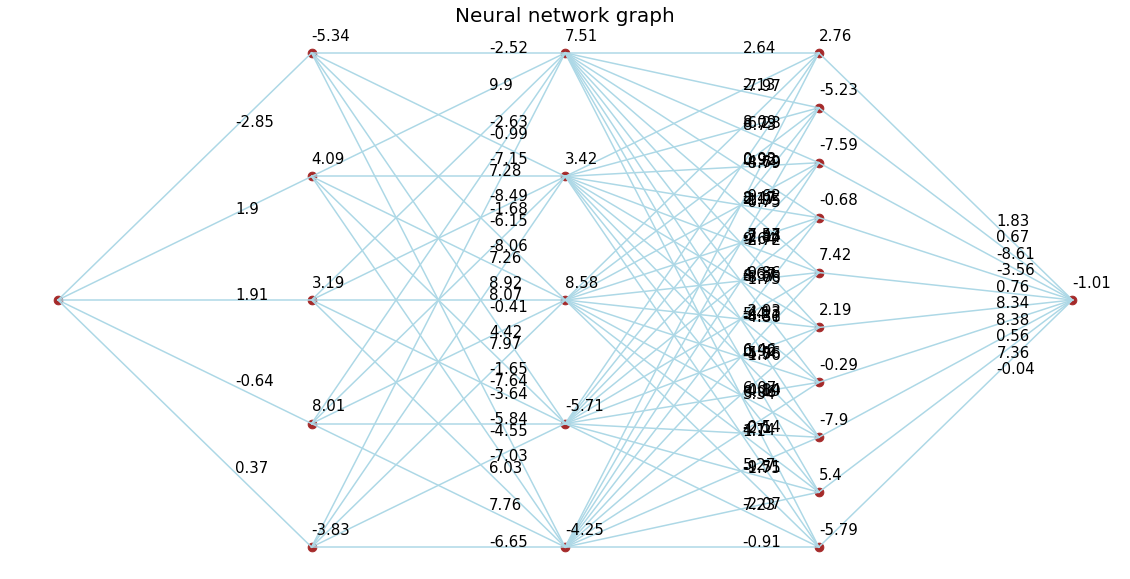

In [3]:
mymlp = generate_random_mlp(1,[5,5,10],1)
mymlp.visualize()

## Testowanie poprawności kodu

In [4]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/square-simple-test.csv', index_col=0)

In [5]:
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])
df

,x,y,split
1,-0.171543,-127.351580,train
2,0.025201,-129.942844,train
3,-1.368991,38.672367,train
4,1.907390,197.432191,train
5,0.011129,-129.988852,train
...,...,...,...
96,1.315377,25.719403,test
97,-1.196968,-1.054107,test
98,1.544766,84.767303,test
99,0.441051,-112.492699,test


Text(0.5, 1.0, 'Train split')

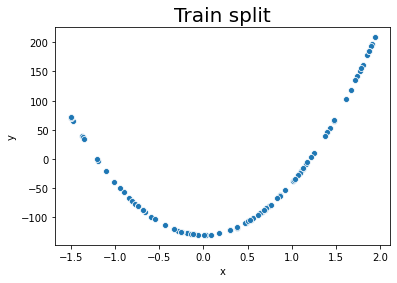

In [6]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

In [7]:
mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
mymlp.show_attributes()

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 5, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid


### sieć przed trenowaniem (losowe wagi)

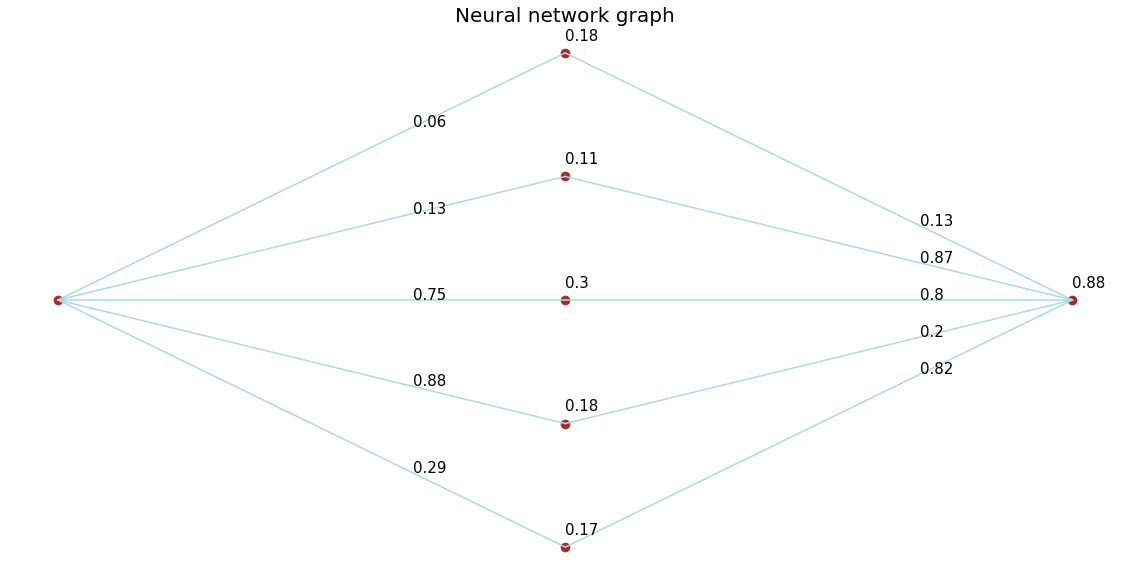

In [8]:
mymlp.visualize()

In [9]:
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 100, 30000, 0.001)

Epoch: 0     Error: 1012.3006106308204
Epoch: 29999 Error: 480.052968130683


### sieć po trenowaniu

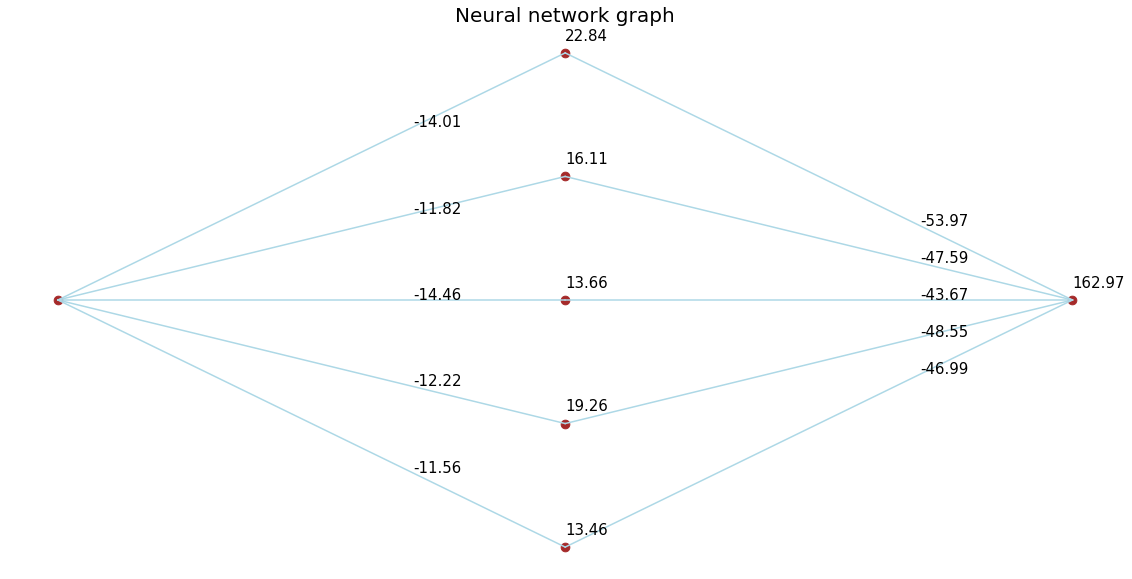

In [10]:
mymlp.visualize()

In [11]:
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))

Text(0.5, 1.0, 'Test performance')

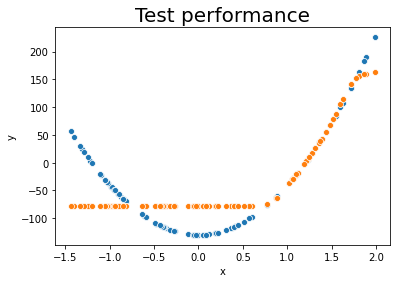

In [12]:
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance', fontsize=20)

Sieć uczy się prawidłowo, jednak to dobrego dopasowania wag potrzebny jest mały krok oraz duża liczba iteracji.

Sprawdżmy w jakim stopniu propagacja wsteczna błędu przyda się do ulepszenia sieci z poprzedniego tygodnia (wykorzystującej ręcznie dobrane wagi). Wyglądała wtedy następująco:

In [13]:
weights_1 = [np.array([[1, 1, 1, 1, 1]]), np.array([[900], [200], [0], [-200], [-900]])]
bias_1 = [np.array([-2, -1, 0, 1, 2]), np.array([650])]
mlp_1 = MLP(weights=weights_1, bias=bias_1)
mlp_1.show_attributes()

Neural Network attributes:
-------------------------
Number of neurons in layers: [1, 5, 1]
Number of predictors: 1
Number of hidden layers: 1
Number of targets: 1
Activations function used: sigmoid


Text(0.5, 1.0, 'Train performance')

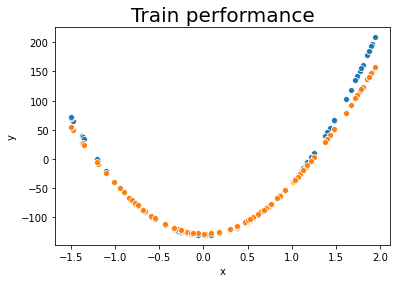

In [14]:
res = mlp_1.forward_prop(np.asarray(train_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=train_df)
sns.scatterplot(x=train_df['x'], y=np.concatenate(res))
plt.title('Train performance', fontsize=20)

Text(0.5, 1.0, 'Test performance')

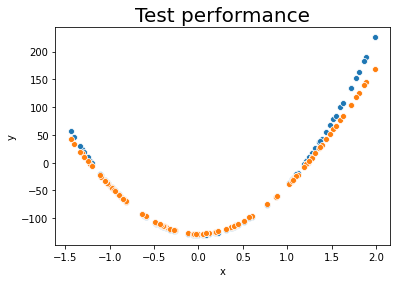

In [15]:
result = mlp_1.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance', fontsize=20)

Po użyciu zaimplementowanej techniki:

In [16]:
mlp_1.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 100, 1000, 0.00001)

Epoch: 0     Error: 151.06991213082432
Epoch: 999   Error: 38.33499705409695


Text(0.5, 1.0, 'Train performance')

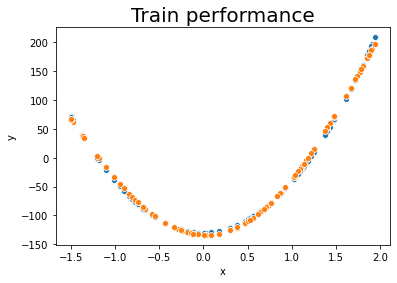

In [17]:
res = mlp_1.forward_prop(np.asarray(train_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=train_df)
sns.scatterplot(x=train_df['x'], y=np.concatenate(res))
plt.title('Train performance', fontsize=20)

Text(0.5, 1.0, 'Test performance')

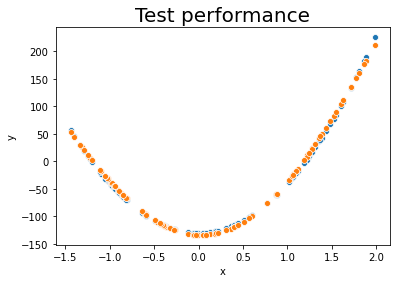

In [18]:
result = mlp_1.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance', fontsize=20)

Test wypadł zdecydowanie dobrze. Przy 1000 epokach sieć lepiej przewiduje obserwacje na "ogonach" paraboli. Przejdźmy teraz do porównywania szybkości i jakości trenowania dla podejść z oraz bez podejścia batchowego; wagi początokowe są z przedziału [0,1].

## Pierwszy zbiór

Epoch: 0     Error: 1012.6055641171241
Epoch: 9999  Error: 505.1178391014326
Czas uczenia bez podejścia batchowego: 1.325779676437378


Text(0.5, 1.0, 'Test performance without batches')

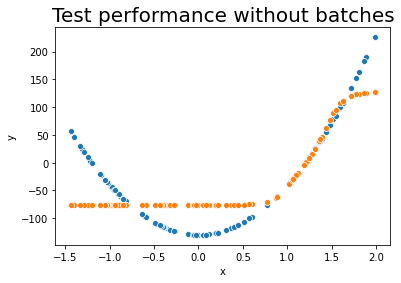

In [19]:
mymlp = mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
start = time.time()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 100, 10000, 0.001)
end = time.time()
print("Czas uczenia bez podejścia batchowego: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance without batches', fontsize=20)

Epoch: 0     Error: 428.71949911384166
Epoch: 0     Error: 288.358012593396
Epoch: 0     Error: 304.06312592640523
Epoch: 0     Error: 272.23830945690804
Epoch: 0     Error: 265.6370651689775
Epoch: 0     Error: 312.2545814193485
Epoch: 0     Error: 342.39288548285907
Epoch: 0     Error: 299.36734380702177
Epoch: 0     Error: 366.5152535516406
Epoch: 0     Error: 282.44007056808124
Epoch: 9999  Error: 18.519407852160537
Epoch: 9999  Error: 11.157144788199748
Epoch: 9999  Error: 21.991823708998847
Epoch: 9999  Error: 26.53778336672948
Epoch: 9999  Error: 26.029884470743713
Epoch: 9999  Error: 27.631783619832255
Epoch: 9999  Error: 23.947128339463298
Epoch: 9999  Error: 19.128185394922475
Epoch: 9999  Error: 13.722240549558549
Epoch: 9999  Error: 20.44532441753161
Czas uczenia z podejściem batchowego: 8.678256511688232


Text(0.5, 1.0, 'Test performance with batches')

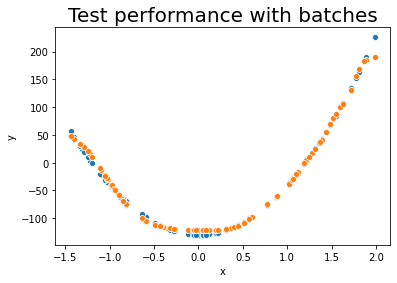

In [20]:
mymlp = mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
start = time.time()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 10, 10000, 0.001)
end = time.time()
print("Czas uczenia z podejściem batchowego: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with batches', fontsize=20)

Pamiętajmy, że na błąd na całym zbiorze składają błędy ze każdego batchu!

Podejście batchowe dało lepsze wyniki ale po około 5-6 razy dłuższym czasie. Przetestujmy podejście bez batchy z 5-krotnie zwiększoną liczbą epok:

Epoch: 0     Error: 1011.7059704365965
Epoch: 49999 Error: 475.2253137336095
Czas uczenia bez podejścia batchowego: 7.022899866104126


Text(0.5, 1.0, 'Test performance without batches')

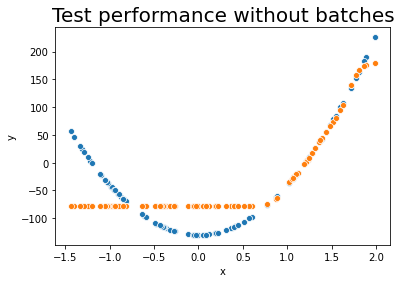

In [21]:
mymlp = mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
start = time.time()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 100, 50000, 0.001)
end = time.time()
print("Czas uczenia bez podejścia batchowego: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance without batches', fontsize=20)

Dla tego zbioru lepiej radzi sobie podejście batchowe.

### Drugi zbiór

In [22]:
train_df = pd.read_csv('/home/szwagier/Documents/Sem6/MIO/datasets/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('/home/szwagier/Documents/Sem6/MIO/datasets/regression/steps-large-test.csv', index_col=0)

In [23]:
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])
train_df

,x,y,split
1,-1.481354,-80,train
2,1.033264,80,train
3,-0.076403,0,train
4,-1.419785,-80,train
5,-0.108398,0,train
...,...,...,...
9996,1.281784,80,train
9997,0.460459,0,train
9998,0.810917,80,train
9999,0.644318,80,train


Text(0.5, 1.0, 'Train split')

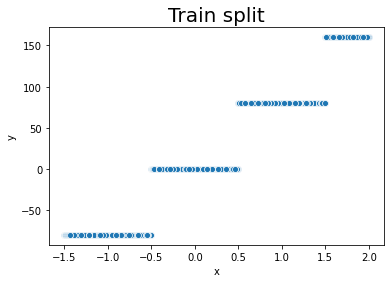

In [24]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

Epoch: 0     Error: 8508.898362798132
Epoch: 9999  Error: 1785.0913516986986
Czas uczenia bez podejścia batchowego: 167.9605143070221


Text(0.5, 1.0, 'Test performance without batches')

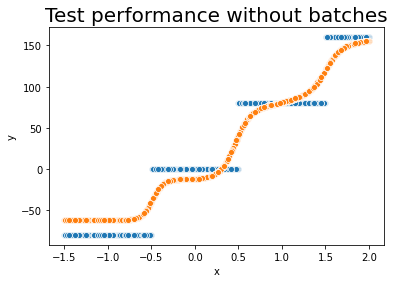

In [25]:
mymlp = mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
start = time.time()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 10000, 10000, 0.001)
end = time.time()
print("Czas uczenia bez podejścia batchowego: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance without batches', fontsize=20)

Epoch: 0     Error: 2651.0777383235163
Epoch: 0     Error: 2559.0801837189124
Epoch: 0     Error: 2675.071836484453
Epoch: 0     Error: 2758.5353611867176
Epoch: 0     Error: 2641.778684817383
Epoch: 0     Error: 2618.042876825126
Epoch: 0     Error: 2591.932438582282
Epoch: 0     Error: 2746.022742464541
Epoch: 0     Error: 2613.550359234911
Epoch: 0     Error: 2603.2194372858844
Epoch: 9999  Error: 241.79764504629185
Epoch: 9999  Error: 265.98823896629636
Epoch: 9999  Error: 242.69687816448854
Epoch: 9999  Error: 269.7845100982098
Epoch: 9999  Error: 213.68628788260966
Epoch: 9999  Error: 255.10958143580308
Epoch: 9999  Error: 247.123355150462
Epoch: 9999  Error: 247.05435974560757
Epoch: 9999  Error: 250.0673826768498
Epoch: 9999  Error: 255.78268370300356
Czas uczenia z podejściem batchowym: 54.25921893119812


Text(0.5, 1.0, 'Test performance with batches')

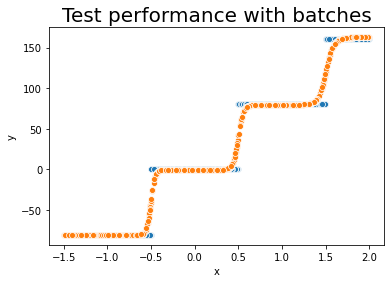

In [33]:
mymlp = mymlp = generate_random_mlp(1, [5], 1, start=0, stop=1)
start = time.time()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 1000, 10000, 0.001)
end = time.time()
print("Czas uczenia z podejściem batchowym: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with batches', fontsize=20)

Tutaj podejście batchowe radzi sobie znacznie lepiej niż w przypadku bezbatchowym.

## Trzeci zbiór

In [27]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-large-test.csv', index_col=0)

In [28]:
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df])
train_df

,x,y,split
1,-0.685726,-80,train
2,-0.879898,-80,train
3,1.411932,80,train
4,1.688954,160,train
5,-0.573238,-80,train
...,...,...,...
9996,-0.194391,0,train
9997,1.012924,80,train
9998,0.569789,80,train
9999,0.538241,80,train


Text(0.5, 1.0, 'Train split')

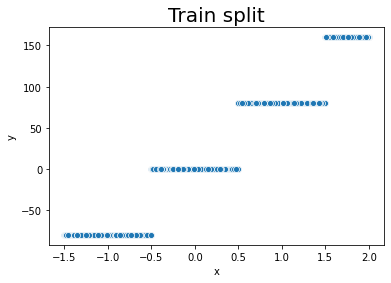

In [29]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

Epoch: 0     Error: 8370.228694855601
Epoch: 9999  Error: 1192.0335634475061
Czas uczenia bez podejścia batchowego: 305.5159900188446


Text(0.5, 1.0, 'Test performance without batches')

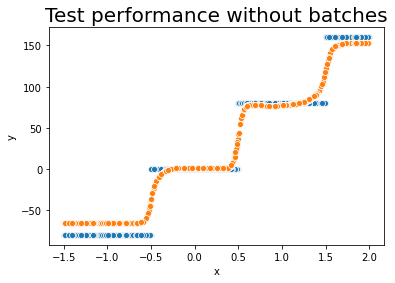

In [30]:
mymlp = mymlp = generate_random_mlp(1, [5, 5], 1, start=0, stop=1)
start = time.time()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 10000, 10000, 0.001)
end = time.time()
print("Czas uczenia bez podejścia batchowego: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance without batches', fontsize=20)

Epoch: 0     Error: 2661.4915451602146
Epoch: 0     Error: 2569.713115128759
Epoch: 0     Error: 2686.5700332874967
Epoch: 0     Error: 2770.5711850299267
Epoch: 0     Error: 2654.1133620106793
Epoch: 0     Error: 2630.749834690652
Epoch: 0     Error: 2605.1841432742526
Epoch: 0     Error: 2760.2781385108424
Epoch: 0     Error: 2628.0304847151197
Epoch: 0     Error: 2618.1765089335117
Epoch: 1999  Error: 197.7084240730757
Epoch: 1999  Error: 225.5655543849059
Epoch: 1999  Error: 205.82595414651544
Epoch: 1999  Error: 230.28976843280006
Epoch: 1999  Error: 178.64510347419636
Epoch: 1999  Error: 221.3964381233162
Epoch: 1999  Error: 212.88688881896292
Epoch: 1999  Error: 202.73759572881556
Epoch: 1999  Error: 207.14197148231128
Epoch: 1999  Error: 212.1812360664387
Czas uczenia z podejściem batchowym: 22.294228553771973


Text(0.5, 1.0, 'Test performance with batches')

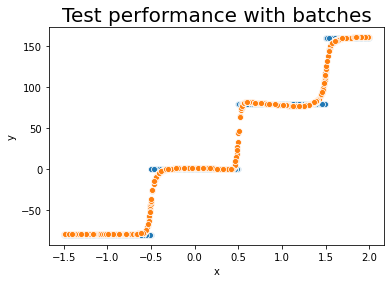

In [31]:
mymlp = mymlp = generate_random_mlp(1, [5, 5], 1, start=0, stop=1)
start = time.time()
mymlp.train(np.asarray(train_df['x']).reshape(-1,1), np.asarray(train_df['y']).reshape(-1,1), 1000, 2000, 0.001)
end = time.time()
print("Czas uczenia z podejściem batchowym: {}".format(end-start))
result = mymlp.forward_prop(np.asarray(test_df['x']).reshape(-1,1))
sns.scatterplot(x='x', y='y', data=test_df)
sns.scatterplot(x=test_df['x'], y=np.concatenate(result))
plt.title('Test performance with batches', fontsize=20)

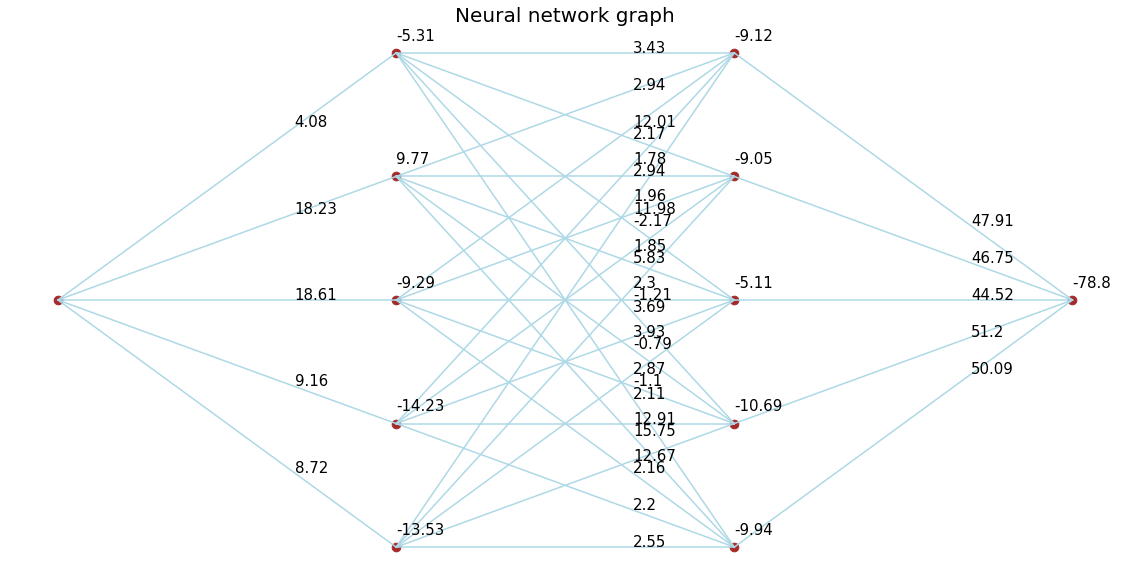

In [32]:
mymlp.visualize()

Tutaj podobnie jak w przypadku drugiego zbioru - podejście batchowe dopasowuje się lepiej i szybciej.

## Wnioski
1. Przy wszystkich zbiorach lepiej radziło sobie podejście batchowe.
2. Przy większych zbiorach podejście batchowe jest szybsze i daje lepszy model.